# 1. Постановка задачи 

**Задача:**
Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды по данным с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Этапы технологического процесса очистки золота**

1. Флотация  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка   
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

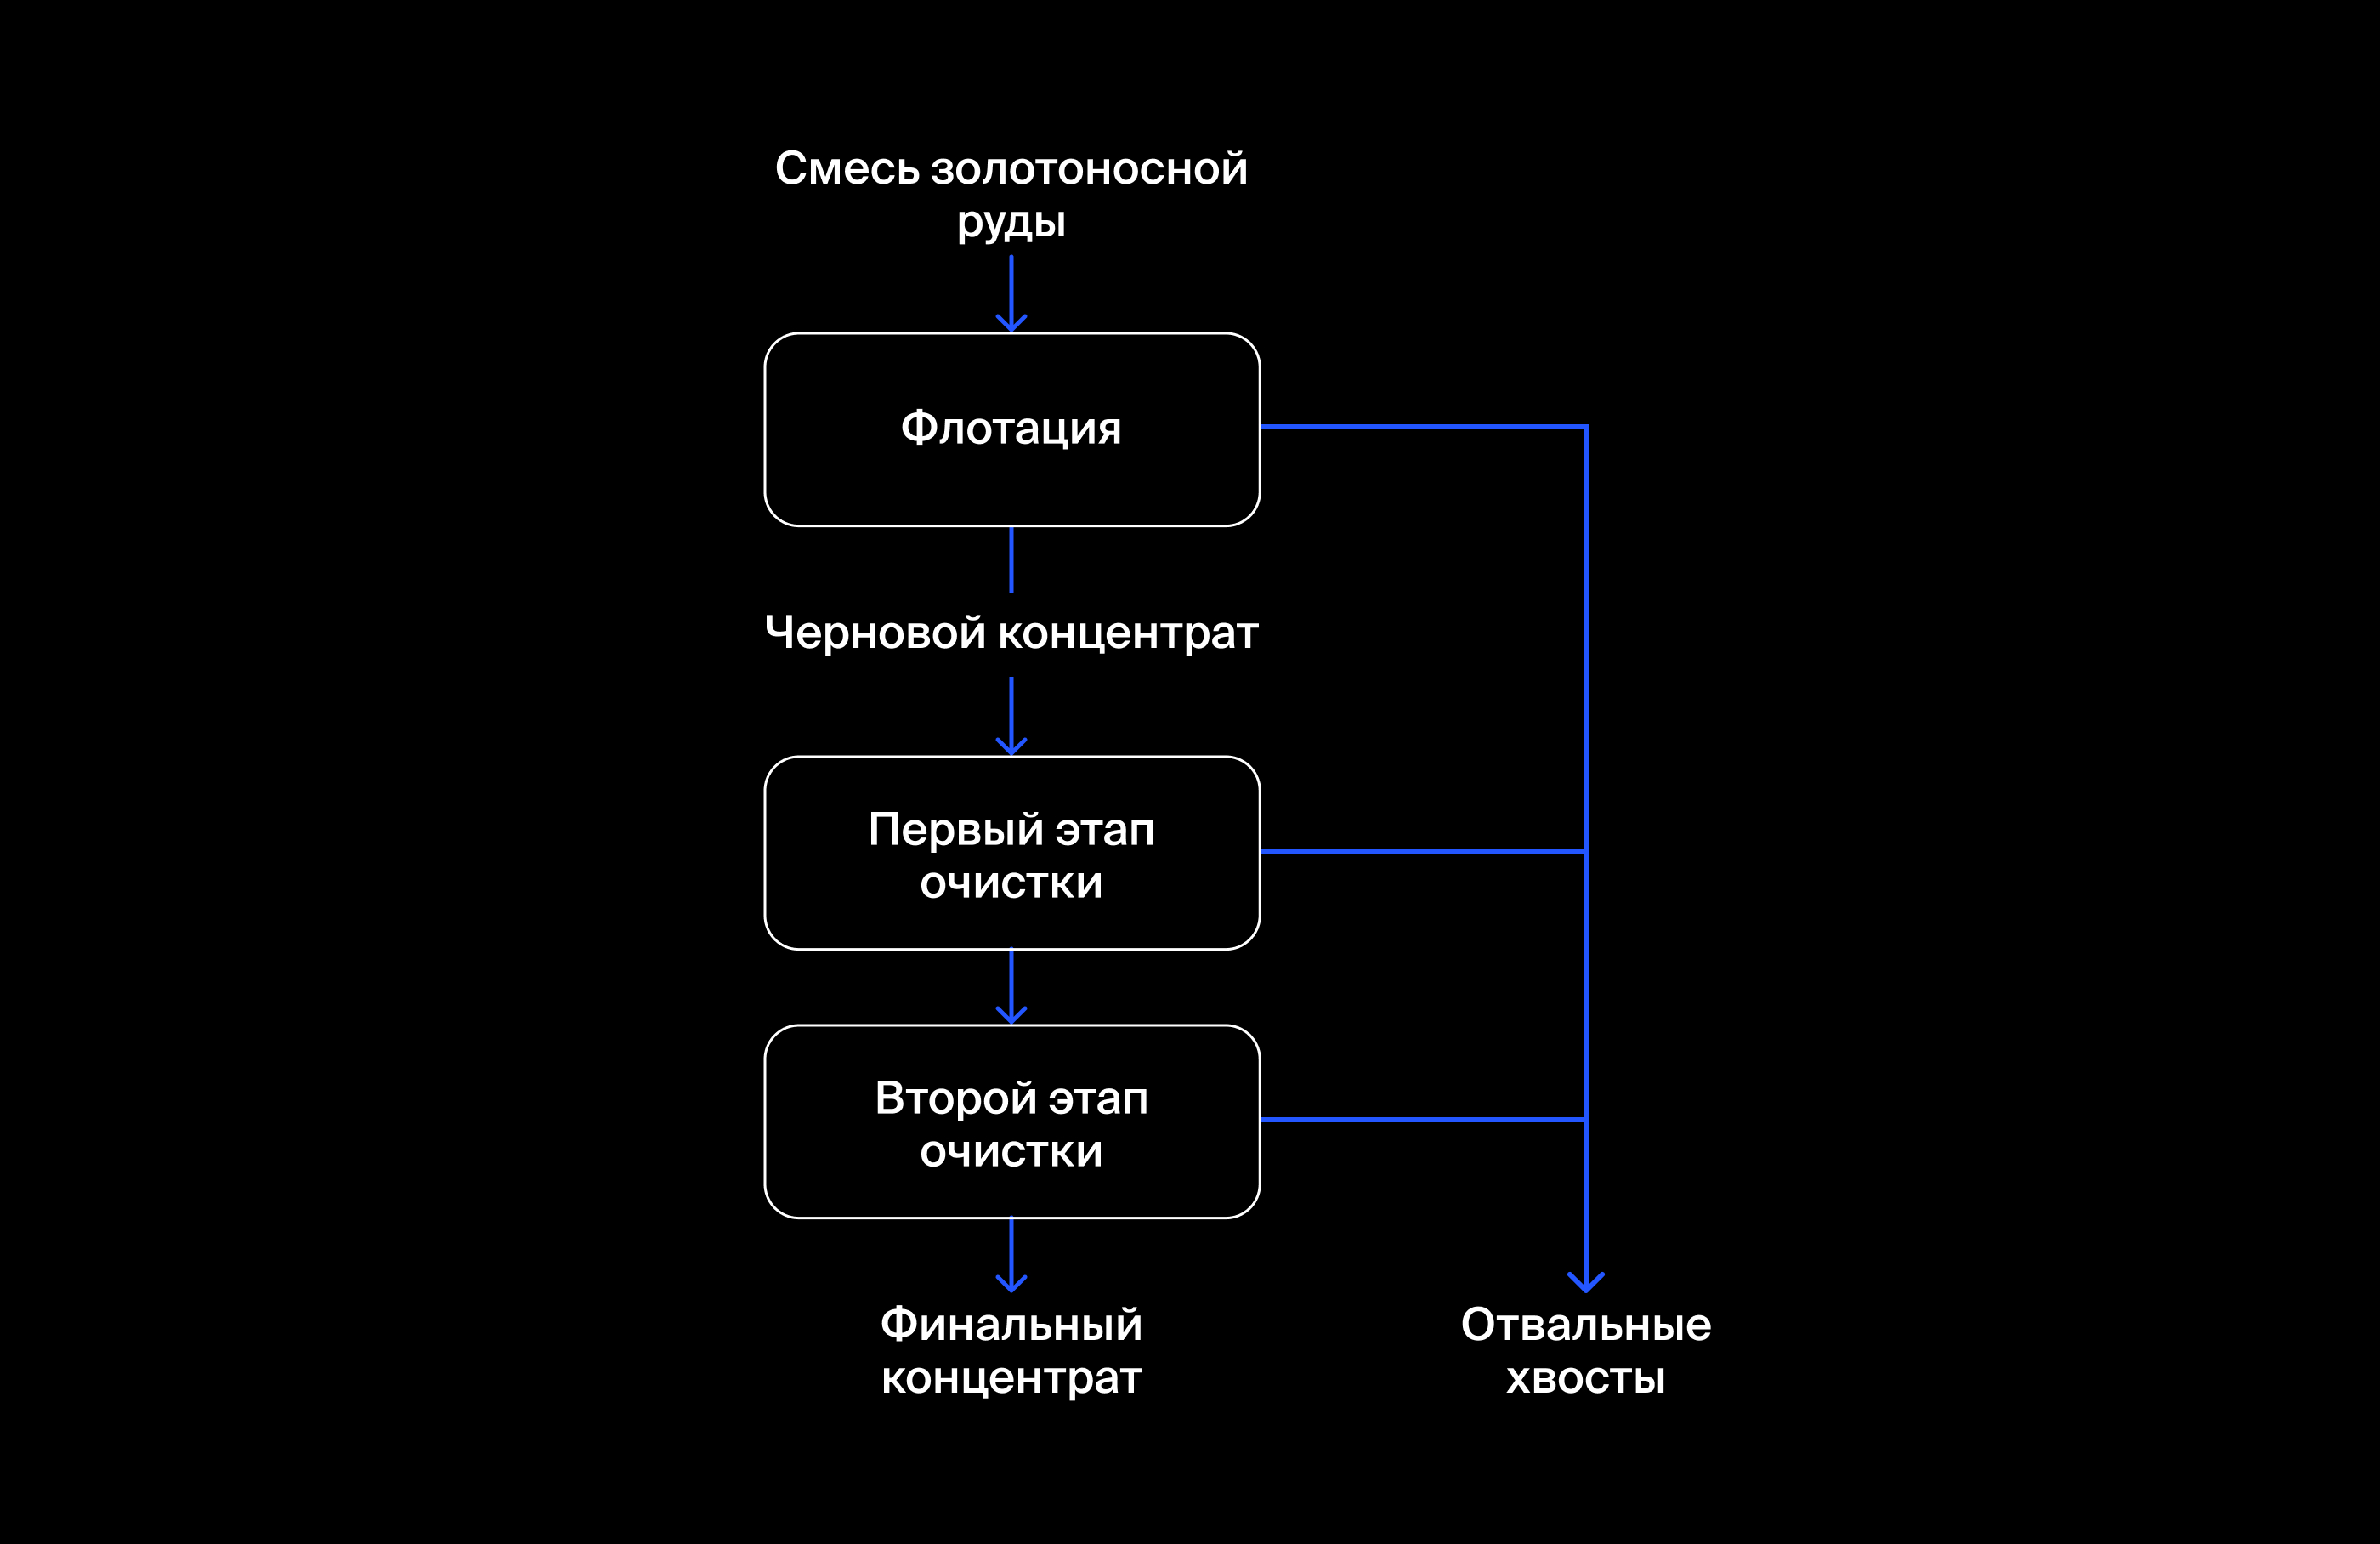

**Описание данных**  

Технологический процесс:  
  
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
Xanthate — ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  
  
Параметры этапов: 
  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  

**Наименование признаков** 
  
Наименование признаков должно быть такое:  
  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
  
Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
  
Возможные значения для блока [тип_параметра]:  
  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

**Расчет эффективности**

Эффективность обогащения рассчитывается по формуле

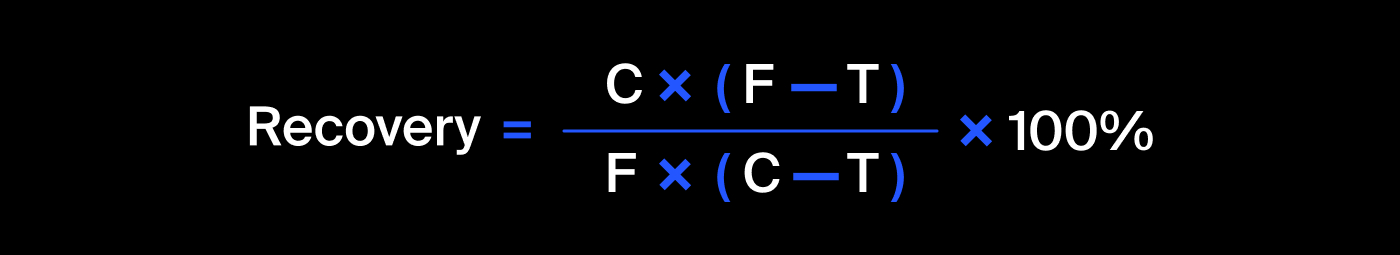

где:  
 - C — доля золота в концентрате после флотации/очистки;
 - F — доля золота в сырье/концентрате до флотации/очистки;
 - T — доля золота в отвальных хвостах после флотации/очистки.
  
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества**

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

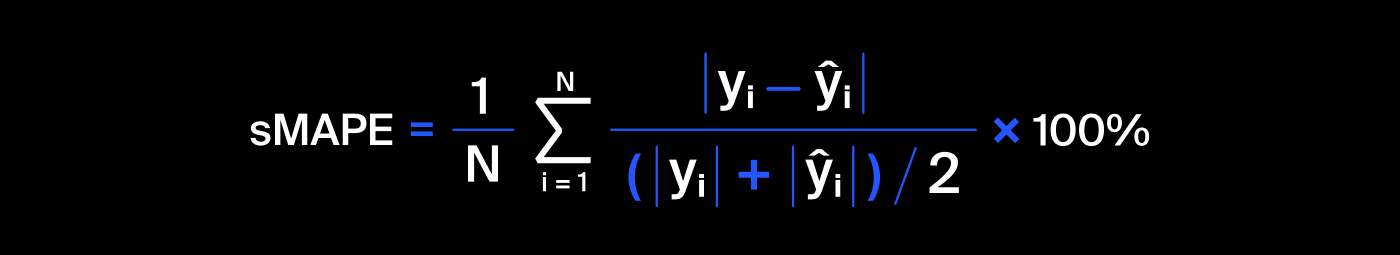

Итоговая метрика складывается из двух величин:

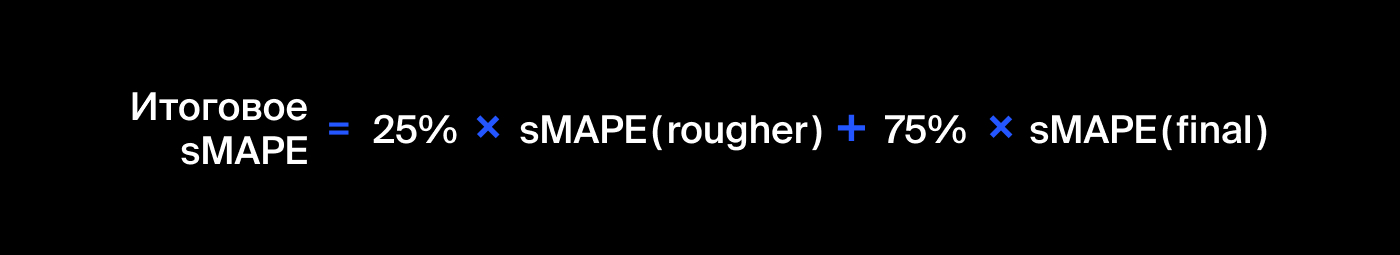

# 2. Загрузка данных 

## 2.1. Импорт библиотек и загрузка данных 

**Импорт библиотек**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, f1_score, log_loss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats as st
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold, TimeSeriesSplit, LeaveOneOut

**Импорт данных**

In [2]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1)
    except OSError as e:
        df = pd.read_csv(pth2)
    return df

In [3]:
pth1 = (['\Сборный проект 2\datasets\gold_industry_train.csv', 
         '\Сборный проект 2\datasets\gold_industry_test.csv', 
         '\Сборный проект 2\datasets\gold_industry_full.csv' ])
pth2 = (['https://code.s3.yandex.net/datasets/gold_industry_train.csv',
         'https://code.s3.yandex.net/datasets/gold_industry_test.csv',
         'https://code.s3.yandex.net/datasets/gold_industry_full.csv'])

In [4]:
train = read_data_set(pth1[0], pth2[0]);
test= read_data_set(pth1[1], pth2[1]);
full = read_data_set(pth1[2], pth2[2]);

**Проверка импорта данных**

In [5]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


In [6]:
train.sample(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
6766,2016-12-08 15:59:59,10.878758,9.833013,4.197720,29.165667,172.790662,96.740031,12.998978,5.799297,1298.409037,...,0.000000,33.467769,8.004902,8.484949,8.170452,75.486660,3.533851,9.264333,3.388795,6.793427
3657,2016-07-17 17:59:59,8.717933,9.039515,3.992259,45.671453,481.882820,82.113988,9.998018,5.599894,998.390209,...,8.450242,47.417979,3.998595,10.354338,9.158158,62.439579,3.699143,8.714087,3.220951,9.344139
742,2016-02-18 02:00:00,9.251240,12.345095,4.432564,30.683462,351.068917,42.256578,10.184423,5.587991,1100.391422,...,11.202148,42.018875,4.847601,12.333665,12.016139,69.598874,3.321442,13.117657,2.711816,10.966957
14075,2017-11-18 00:59:59,5.184006,6.059875,4.101351,35.736085,540.869924,72.805986,8.051670,6.099976,1000.246620,...,NaN,46.857597,3.541172,10.451513,6.852307,70.951338,1.634159,9.942140,3.057259,8.023571
14010,2017-11-15 07:59:59,6.326249,5.566431,4.346551,35.646480,540.907959,83.204054,10.852253,6.298796,1002.938872,...,NaN,46.713401,3.394056,11.077480,6.755020,67.404451,2.269218,9.624698,3.162165,7.688780


In [7]:
train.isna().sum().to_frame(name="nans").query("nans > 0")["nans"]

rougher.input.feed_pb                                  72
rougher.input.feed_sol                                 77
rougher.input.feed_rate                                 7
rougher.input.feed_size                               101
rougher.input.floatbank10_sulfate                      31
rougher.input.floatbank10_xanthate                      7
rougher.state.floatbank10_e_air                       429
rougher.input.floatbank11_sulfate                      36
rougher.input.floatbank11_xanthate                    407
rougher.calculation.sulfate_to_au_concentrate           1
rougher.calculation.floatbank10_sulfate_to_au_feed      1
rougher.calculation.floatbank11_sulfate_to_au_feed      1
rougher.output.concentrate_sol                         18
rougher.output.tail_ag                                  1
primary_cleaner.input.sulfate                          23
primary_cleaner.input.depressant                       28
primary_cleaner.input.xanthate                         61
primary_cleane

In [8]:
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


In [9]:
test.isna().sum().to_frame(name="nans").query("nans > 0")["nans"]

rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_e_air                 7
rougher.input.floatbank11_sulfate               8
rougher.input.floatbank11_xanthate             46
primary_cleaner.input.sulfate                   1
primary_cleaner.input.depressant                9
primary_cleaner.input.xanthate                 43
primary_cleaner.state.floatbank8_a_air          1
primary_cleaner.state.floatbank8_a_level        1


In [10]:
full.info()
full.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


In [11]:
full.sample(5)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
4965,2016-09-14 18:59:59,9.593088,10.508048,3.055710,36.645463,478.849938,45.652490,12.998893,5.997956,1001.017735,...,9.191544,45.449518,6.124491,8.594139,14.284685,75.969368,2.745523,9.787152,2.318453,8.914914
7698,2017-01-23 15:59:59,7.318620,7.539853,3.454167,36.980572,459.105204,48.506292,13.998367,4.971953,1299.848722,...,8.322065,45.163710,3.024358,9.881477,8.557356,59.364356,3.290508,7.244769,3.072130,11.531532
2532,2016-05-25 08:59:59,5.587243,8.602306,0.716649,37.775948,549.029225,49.520604,9.001960,4.601461,999.463500,...,12.502303,49.278457,4.735556,6.455581,8.964635,69.672271,1.839821,8.364744,0.882320,13.166204
322,2016-01-30 05:00:00,5.559508,9.000479,2.271835,21.883425,301.195902,55.812598,6.058992,5.298708,998.022040,...,8.166356,44.217351,6.337337,8.924292,NaN,59.605069,2.427696,11.780129,1.758298,10.203091
10736,2017-06-20 04:59:59,8.549369,10.228837,2.529752,42.882596,648.669663,86.946417,15.644585,7.700762,1199.415095,...,7.306768,45.385886,5.981255,9.085702,9.345454,73.005331,2.675860,10.605379,2.110836,13.747821


In [12]:
full.isna().sum().to_frame(name="nans").query("nans > 0")["nans"]

rougher.input.feed_pb                100
rougher.input.feed_sol                99
rougher.input.feed_rate               11
rougher.input.feed_size              145
rougher.input.floatbank10_sulfate     34
                                    ... 
final.output.concentrate_pb            1
final.output.concentrate_sol         211
final.output.tail_ag                   1
final.output.tail_pb                 101
final.output.tail_sol                  6
Name: nans, Length: 63, dtype: int64

## 2.2. Расчет эффективности

Сделаем функцию для расчета эффективности

In [13]:
def recovery (c:float, f:float, t:float) -> float:
    return c*(f-t)/(f*(c-t)) * 100    

Сделаем функцию для проверки расчета эффективности

In [14]:
def check_flotation(df:pd.DataFrame, target:str) -> pd.Series:
    output = []
    for i, row in df.iterrows():        
            c = row['rougher.output.concentrate_au']
            f = row['rougher.input.feed_au']
            t = row['rougher.output.tail_au']   
            output.append(recovery(c, f, t))      
    
    output = pd.Series(output, index=df.index)
    return output

In [15]:
mean_absolute_error(train['rougher.output.recovery'], check_flotation(train, 'rougher.output'))

9.83758577644259e-15

**Вывод:** MAE составляет 9 в минус 15-ой степени. Это укладывается в погрешность машинных вычислений. Эффективность обогащения обучающей выборки посчитана правильно  

## 2.3. Признаки тестовой выборки 

In [16]:
difference = full.drop(columns = test.columns)

In [17]:
difference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       19437 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  19437 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  19437 non-null  float64
 3   rougher.calculation.au_pb_ratio                     19439 non-null  float64
 4   rougher.output.concentrate_au                       19439 non-null  float64
 5   rougher.output.concentrate_ag                       19439 non-null  float64
 6   rougher.output.concentrate_pb                       19439 non-null  float64
 7   rougher.output.concentrate_sol                      19416 non-null  float64
 8   rougher.output.recovery                             19439 non-null  float64


**Вывод:**
В тестовом датасете отсутствуют как расчетные данные так и результаты (концентрации элементов) в продукте и хвостах (целевые признаки). Все типа float. Так же отсутствуют эффективности обогащения. На этапе тестирования модели их придется брать каким-то образом. 

## 2.4. Предобработка данных

Удалим дубликаты 

In [18]:
train.duplicated() == True

0        False
1        False
2        False
3        False
4        False
         ...  
14574    False
14575    False
14576    False
14577    False
14578    False
Length: 14579, dtype: bool

In [19]:
test.duplicated() == True

0       False
1       False
2       False
3       False
4       False
        ...  
4855    False
4856    False
4857    False
4858    False
4859    False
Length: 4860, dtype: bool

In [20]:
full.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
19434    False
19435    False
19436    False
19437    False
19438    False
Length: 19439, dtype: bool

In [21]:
train = train.drop_duplicates(keep='first').reset_index(drop=True)
test = test.drop_duplicates(keep='first').reset_index(drop=True)
full = full.drop_duplicates(keep='first').reset_index(drop=True)

In [22]:
train.shape[0] + test.shape[0] == full.shape[0]

True

В связи с тем, что линейная регрессия не может работать с NaN, придется от них избавится

Единичные значения NaN, которые скорее всего вызваны ошибками при сборе признаков, можно удалить 

In [23]:
def drop_na_10(df:pd.DataFrame)->pd.DataFrame:
    columns = df.isna().sum() > 10
    columns = pd.DataFrame(columns)
    columns = columns[columns.values == True].index.to_list()
    return df.dropna(subset= df.columns.drop(columns)).reset_index(drop= True)

In [24]:
train = drop_na_10(train)

In [29]:
train.isna().sum().to_frame(name="nans").query("nans > 0")["nans"]

rougher.input.feed_pb                        72
rougher.input.feed_sol                       70
rougher.input.feed_size                     100
rougher.input.floatbank10_sulfate            21
rougher.state.floatbank10_e_air             426
rougher.input.floatbank11_sulfate            32
rougher.input.floatbank11_xanthate          397
rougher.output.concentrate_sol               17
primary_cleaner.input.sulfate                15
primary_cleaner.input.depressant             20
primary_cleaner.input.xanthate               52
primary_cleaner.output.concentrate_pb        85
primary_cleaner.output.concentrate_sol      259
primary_cleaner.output.tail_sol              43
secondary_cleaner.state.floatbank2_a_air     92
secondary_cleaner.state.floatbank2_b_air     17
secondary_cleaner.state.floatbank3_a_air     12
secondary_cleaner.output.tail_sol           912
final.output.concentrate_sol                192
final.output.tail_pb                         74
Name: nans, dtype: int64

Очень врядли, что параметры сырья на всех этапах сильно меняются, так как технологический процесс отлажен под определенные содержания веществ и размеры. Заполним NaN средними значениями

In [31]:
def fillna_by_mean(columns:list, df:pd.DataFrame)-> pd.DataFrame:
    for column in columns:
        df[column] = df[column].fillna(df[column].mean())           
    return df

In [32]:
columns = (['rougher.input.feed_pb',                        
            'rougher.input.feed_sol',                       
            'rougher.input.feed_size',                     
            'rougher.input.floatbank10_sulfate',
            'rougher.state.floatbank10_e_air',
            'rougher.input.floatbank11_sulfate',
            'rougher.input.floatbank11_xanthate',
            'rougher.output.concentrate_sol',
            'primary_cleaner.input.sulfate',                
            'primary_cleaner.input.depressant',             
            'primary_cleaner.input.xanthate',
            'primary_cleaner.output.concentrate_pb',
            'primary_cleaner.output.concentrate_sol',      
            'primary_cleaner.output.tail_sol',              
            'secondary_cleaner.state.floatbank2_a_air',
            'secondary_cleaner.state.floatbank2_b_air',
            'secondary_cleaner.state.floatbank3_a_air',
            'secondary_cleaner.output.tail_sol',
            'final.output.concentrate_sol',
            'final.output.tail_pb'])

In [33]:
train = fillna_by_mean(columns, train)

In [34]:
train.isna().sum().to_frame(name="nans").query("nans > 0")["nans"]

Series([], Name: nans, dtype: int64)

In [35]:
columns = (['rougher.input.feed_pb',
            'rougher.input.feed_sol',
            'rougher.input.feed_size',                      
            'rougher.input.floatbank11_xanthate',
            'primary_cleaner.input.xanthate',
            'secondary_cleaner.state.floatbank2_a_air'])

In [38]:
train.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,...,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000,14538.000000
mean,8.355337,8.879608,3.605053,36.575662,474.636151,58.939581,12.432872,5.999022,1104.384490,-379.417786,...,7.115948,44.008944,5.194126,9.928386,9.574048,66.790693,3.089567,9.737638,2.722006,10.622123
std,1.933405,1.920747,1.053054,5.159392,107.997186,22.334015,3.423047,1.146480,161.680323,94.636080,...,3.778441,5.373006,1.382444,1.689828,2.779344,10.469949,0.912350,2.348068,0.954940,2.859581
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.041078,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.934029,7.342869,2.886768,34.126849,411.567281,47.341078,10.003009,5.310084,999.646658,-499.862591,...,4.029820,43.354413,4.283730,9.104588,7.883873,63.125596,2.505600,8.091523,2.044564,9.021877
50%,8.231001,8.716928,3.542047,37.074300,498.278941,54.472518,12.003582,6.003338,1000.984678,-300.314252,...,7.231212,44.978870,5.118278,10.049308,9.350917,67.967475,3.029927,9.820900,2.770764,10.675597
75%,9.833224,10.257268,4.254729,39.881524,549.626178,64.317084,14.929685,6.796839,1292.705387,-299.989391,...,10.219131,46.278026,5.924971,10.981557,10.975025,72.585195,3.614053,11.170350,3.352301,12.135392
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,16.994576,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


Время и дата на результат не виляют. Отбросим данный столбец

In [39]:
train = train.drop(columns='date').reset_index(drop= True)

In [40]:
train.shape

(14538, 86)

In [41]:
test.shape

(4860, 53)

Удалим нулевые значения концентрации металлов, так как они явно ошибочны

In [42]:
def positive_metals(df:pd.DataFrame) -> pd.DataFrame:
    metals = ['au', 'ag', 'pb']
    for metal in metals:
        df = df.loc[df['rougher.input.feed_'+ metal] != 0, :]
        df = df.loc[df['rougher.output.concentrate_'+ metal] != 0, :]
        df = df.loc[df['primary_cleaner.output.concentrate_'+ metal] != 0, :]
        df = df.loc[df['final.output.concentrate_'+ metal] != 0, :]       
    return df

In [43]:
train = positive_metals(train)

Удалим хвост rougher.input.feed_size

In [44]:
train = train.loc[train['rougher.input.feed_size'] < 150].reset_index(drop= True)
#test = test.loc[test['rougher.input.feed_size'] < 150].reset_index(drop= True)

# 3. Анализ данных 

## 3.1. Концентрация металлов на различных этапах

In [45]:
def plot_hist_metal(df:pd.DataFrame):  
    metals = ['au', 'ag', 'pb']
    for metal in metals:
        df['rougher.input.feed_'+ metal].hist(bins=100);
        df['rougher.output.concentrate_' + metal].hist(bins=100);
        df['primary_cleaner.output.concentrate_' + metal].hist(bins=100);
        df['final.output.concentrate_' + metal].hist(bins=100); 
        plt.legend(['сырье', 'после флотации', 'после первичной очистки', 'после вторичной очистки'])
        plt.title(f'Концентрация {metal} на разных этапах')     
        plt.show()
    return

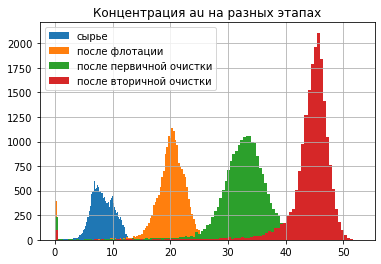

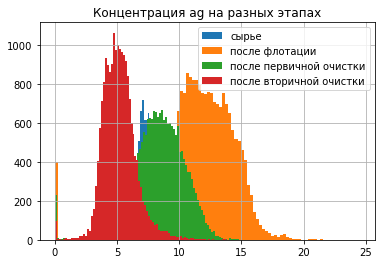

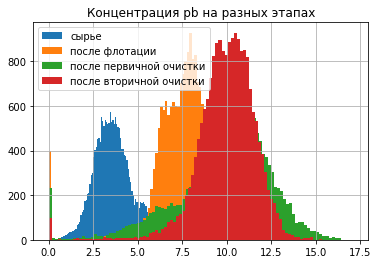

In [46]:
plot_hist_metal(full)

**Вывод:**

Распределения похожи на нормальные. Интересно, что концентрация свинца и серебра возрастает после вторичной очистки
Концентрация золота возрастает на каждом этапе (что логично). Концентрация серебра возрастает после проведеия флотации, уменьшается после проведения первичной очистки и становися максимальной после второй очистки. Концентрация свинца возрастает на каждом этапе

## 3.2. Распределения размеров гранул исходного сырья 

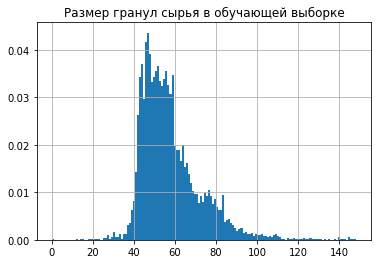

In [47]:
train['rougher.input.feed_size'].hist(bins=150, density=True);  
plt.title('Размер гранул сырья в обучающей выборке')     
plt.show()   

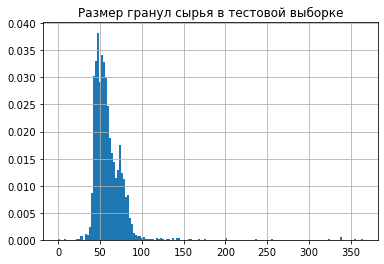

In [48]:
test['rougher.input.feed_size'].hist(bins=150, density=True);  
plt.title('Размер гранул сырья в тестовой выборке')     
plt.show()   

**Вывод:**

Распределения схожи

## 3.3. Суммарная концентрация металлов на разных стадиях

In [49]:
def sums_metal(df:pd.DataFrame) -> pd.DataFrame:  
    metals = ['au', 'ag', 'pb']    
    sums =pd.DataFrame(index = ['rougher.input', 'rougher.output', 'primary_cleaner', 'final'], columns = metals)
    for metal in metals:
        sums.loc['rougher.input', metal] = df['rougher.input.feed_'+ metal].sum()
        sums.loc['rougher.output', metal] = df['rougher.output.concentrate_'+ metal].sum()        
        sums.loc['primary_cleaner', metal] = df['primary_cleaner.output.concentrate_'+ metal].sum()
        sums.loc['final', metal] = df['final.output.concentrate_'+ metal].sum()       
  
    return sums

In [50]:
sums =  sums_metal(full).reset_index(drop= False)

In [51]:
sums.head()

,index,au,ag,pb
0,rougher.input,160684.665932,170964.59423,69583.365339
1,rougher.output,384347.910711,233166.127197,147858.327496
2,primary_cleaner,624369.024529,164111.970623,189936.003827
3,final,856803.335079,100464.727124,193969.759284


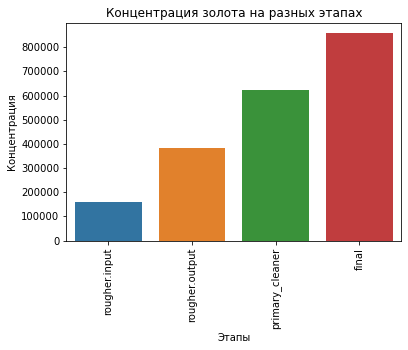

In [52]:
sns.barplot(data= sums, x= 'index', y= 'au');
plt.title('Концентрация золота на разных этапах')     
plt.xlabel('Этапы')
plt.ylabel('Концентрация')
plt.xticks(rotation= 90 )
plt.show()   

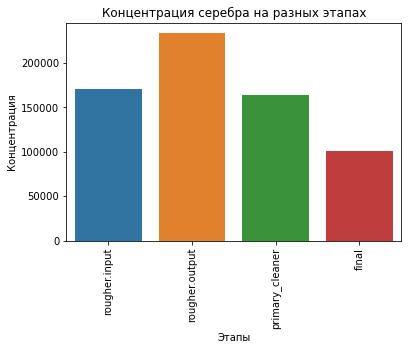

In [53]:
sns.barplot(data= sums, x= 'index', y= 'ag');
plt.title('Концентрация серебра на разных этапах')     
plt.xlabel('Этапы')
plt.ylabel('Концентрация')
plt.xticks(rotation= 90 )
plt.show()   

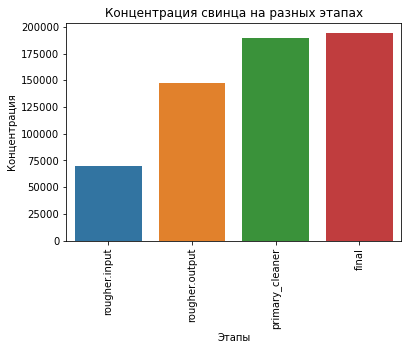

In [54]:
sns.barplot(data= sums, x= 'index', y= 'pb');
plt.title('Концентрация свинца на разных этапах')     
plt.xlabel('Этапы')
plt.ylabel('Концентрация')
plt.xticks(rotation= 90 )
plt.show()   

**Выводы:**

Как и следовало ожидать, финальная концентрация золота почти в 8 раз выше. Существенно так же увеличивается концентрация свинца. Концентрация серебра падает на всех этапах кроме флоатации 

In [89]:
def plot_hist_metal(df:pd.DataFrame):  
    stages = ['rougher', 'primary_cleaner', 'final']
    for stage in stages:
        ((df[stage + '.output.concentrate_au'] + df[stage + '.output.concentrate_pb'] + df[stage + '.output.concentrate_ag'])
         .hist(bins=100, density=True));  
        plt.xlim([30, 65])       
        plt.title(f'Концентрация au+ag+pb на этапе {stage}')     
        plt.show()
    return

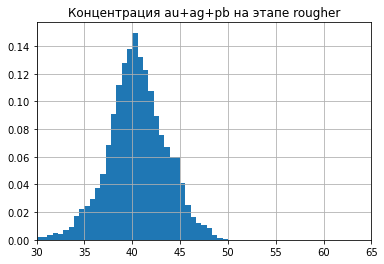

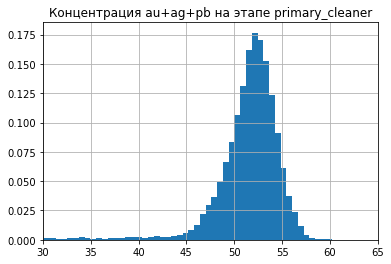

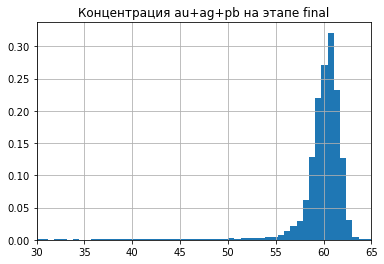

In [90]:
plot_hist_metal(full)

# 4. Построение модели 

## 4.1. sMAPE

Напишем функцию для вычисления sMAPE

In [129]:
def smape (test:pd.Series, predictions:pd.Series) -> float:     
    smape = 0
    for i in range(len(test)):
        smape = smape + abs(test[i]-predictions[i])/((test[i]+predictions[i])/2) * 100
    return smape/test.shape[0]     

In [130]:
def final_smape(rougher:float, final:float) -> float:
    return rougher*0.25 + final*0.75

## 4.2. Обучение моделей 

Подготовим выборки

In [91]:
def make_samples(columns:list, df:pd.DataFrame):
    df_droped = df.drop(columns= columns)
    df_rougher = df[columns[0]]
    df_final = df[columns[1]]
    return df_droped, df_rougher, df_final

In [92]:
features_train, test_train_rougher, test_train_final = (make_samples(['rougher.output.recovery',
                                                                      'final.output.recovery'] , train))

Тестовые выборки получим с помощью функции расчета эффективности, однако данные по концентрациям золота после очистки и в хвостах в тестовой выборке отсутсвуют. Статистически медианная клнцентрация золота после флотации концентрация золота в продукте увеличивается в 4 раза, очистка - 2. Расчитаем необходимые величины для тестовой выборки и найдем эффективность обогащения

In [94]:
def calculate_missing(df:pd.DataFrame) -> pd.DataFrame:
        df['rougher.output.concentrate_au'] = df['rougher.input.feed_au'].apply(lambda x: x*4) 
        df['rougher.output.tail_au'] = df['rougher.input.feed_au'].apply(lambda x: x/4)           
        df['primary_cleaner.output.concentrate_au'] = df['rougher.output.concentrate_au'].apply(lambda x: x*2) 
        df['primary_cleaner.output.tail_au'] = df['rougher.output.concentrate_au'].apply(lambda x: x/2)        
        df['final.output.concentrate_au'] = df['primary_cleaner.output.concentrate_au'].apply(lambda x: x*2) 
        df['final.output.tail_au'] = df['primary_cleaner.output.concentrate_au'].apply(lambda x: x/2)   
        return df      

In [95]:
def calculate_recovery(df:pd.DataFrame) -> pd.DataFrame:
    for i, row in df.iterrows():        
            c = row['rougher.output.concentrate_au']
            f = row['rougher.input.feed_au']
            t = row['rougher.output.tail_au']   
            df.loc[i, 'rougher.output.recovery'] = recovery(c, f, t)    
            c = row['final.output.concentrate_au']
            f = row['primary_cleaner.output.concentrate_au']
            t = row['final.output.tail_au']   
            df.loc[i, 'final.output.recovery'] = recovery(c, f, t)   
    
    return df

In [190]:
test_sample = (test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']], on= 'date')
                .dropna() 
                .reset_index(drop= True))
test_sample.isna().sum()

date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level       

In [191]:
features_valid = test_sample.drop(columns = ['rougher.output.recovery', 'final.output.recovery', 'date'])

In [192]:
test_valid_rougher = test_sample['rougher.output.recovery']
test_valid_final = test_sample['final.output.recovery']

In [193]:
test_valid_final.describe()

count    4537.000000
mean       68.062422
std         8.278314
min         5.586496
25%        64.064129
50%        68.821228
75%        73.148396
max       100.000000
Name: final.output.recovery, dtype: float64

In [220]:
features_valid = test.drop(columns= 'date').dropna()

In [196]:
features_train = features_train[features_valid.columns]

In [197]:
[features_train.shape[0], test_train_rougher.shape[0]]

[13859, 13859]

In [198]:
[features_valid.shape[0], test_valid_rougher.shape[0]]

[4860, 4537]

In [199]:
[features_valid.shape[0], test_valid_final.shape[0]]

[4860, 4537]

Построим модели

In [200]:
def find_params(features_train:pd.DataFrame, target_train:pd.Series, 
                 features_valid:pd.DataFrame, target_valid:pd.Series) -> dict: 
    
    best_result = 10000
    best_depth = 0    
        
    for depth in range(1, 6):
        model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)  
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = smape(target_valid, predictions_valid)
        if result < best_result:           
            best_result = result
            best_depth = depth
            
    print(f'depth_tree: {best_depth} sMAPE_tree: {result}')
    
    best_result = 10000
    best_est = 0
    best_depth = 0
    
    for est in range(10, 51, 10):
        for depth in range (1, 11):
            model = RandomForestRegressor(random_state= 12345,  n_estimators= est, max_depth= depth)
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = smape(target_valid, predictions_valid)
            if result < best_result:          
                best_result = result
                best_est = est
                best_depth = depth
    
    print(f'depth_forest: {best_depth} est_forest : {best_est} sMAPE_forest: {result}')
    
    
    model = LinearRegression()  
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = smape(target_valid, predictions_valid)       
            
    print(f'sMAPE_regression {result}')
    
    return 

In [208]:
def find_params(features_train:pd.DataFrame, target_train:pd.Series) -> dict:  
    
      
    kf = KFold(n_splits=5, shuffle=True)
    for train_index, val_index in kf.split(features_train): 
        
        x_train, x_val = features_train.iloc[train_index].reset_index(drop=True), features_train.iloc[val_index].reset_index(drop=True)
        y_train, y_val = target_train.iloc[train_index].reset_index(drop=True), target_train.iloc[val_index].reset_index(drop=True)    
    
        best_result = 10000
        best_depth = 0 
            
        for depth in range(1, 6):
            model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)  
            model.fit(x_train, y_train)
            predictions_valid = model.predict(x_val)
            result = smape(y_val, predictions_valid)
            if result < best_result:           
                best_result = result
                best_depth = depth
            
            print(f'depth_tree: {best_depth} sMAPE_tree: {result}')
    
        best_result = 10000
        best_est = 0
        best_depth = 0
    
        for est in range(10, 51, 10):
            for depth in range (1, 11):
                model = RandomForestRegressor(random_state= 12345,  n_estimators= est, max_depth= depth)
                model.fit(x_train, y_train)
                predictions_valid = model.predict(x_val)
                result = smape(y_val, predictions_valid)
                if result < best_result:          
                    best_result = result
                    best_est = est
                    best_depth = depth
    
            print(f'depth_forest: {best_depth} est_forest : {best_est} sMAPE_forest: {result}')
    
    
        model = LinearRegression()  
        model.fit(x_train, y_train)
        predictions_valid = model.predict(x_val)
        result = smape(y_val, predictions_valid)          
            
        print(f'sMAPE_regression {result}')
    
    return 

Параметры для флотации

In [209]:
find_params(features_train, test_train_rougher)

depth_tree: 1 sMAPE_tree: 5.869710080318568
depth_tree: 2 sMAPE_tree: 5.291321091317979
depth_tree: 3 sMAPE_tree: 5.006407301449941
depth_tree: 4 sMAPE_tree: 4.676279232147071
depth_tree: 5 sMAPE_tree: 4.335425098113086
depth_forest: 10 est_forest : 10 sMAPE_forest: 3.110038840819769
depth_forest: 10 est_forest : 20 sMAPE_forest: 3.0454159651416486
depth_forest: 10 est_forest : 30 sMAPE_forest: 3.0252949287971034
depth_forest: 10 est_forest : 30 sMAPE_forest: 3.025438169413839
depth_forest: 10 est_forest : 50 sMAPE_forest: 3.0226164976032117
sMAPE_regression 4.4645855347000705
depth_tree: 1 sMAPE_tree: 5.884766561183455
depth_tree: 2 sMAPE_tree: 5.212712620254787
depth_tree: 3 sMAPE_tree: 4.851036529354597
depth_tree: 4 sMAPE_tree: 4.537363667832891
depth_tree: 5 sMAPE_tree: 4.356424133047114
depth_forest: 10 est_forest : 10 sMAPE_forest: 3.031451443308702
depth_forest: 10 est_forest : 20 sMAPE_forest: 2.9951620223581608
depth_forest: 10 est_forest : 30 sMAPE_forest: 2.98250286277313
d

Параметры для второй очистки

In [211]:
find_params(features_train, test_train_final)

depth_tree: 1 sMAPE_tree: 8.915518010559339
depth_tree: 2 sMAPE_tree: 8.59213000007804
depth_tree: 3 sMAPE_tree: 8.115422685647687
depth_tree: 4 sMAPE_tree: 7.928734550002455
depth_tree: 5 sMAPE_tree: 7.803411624550344
depth_forest: 10 est_forest : 10 sMAPE_forest: 6.591785783099008
depth_forest: 10 est_forest : 20 sMAPE_forest: 6.51929046601211
depth_forest: 10 est_forest : 30 sMAPE_forest: 6.497658842400963
depth_forest: 10 est_forest : 40 sMAPE_forest: 6.488972815406432
depth_forest: 10 est_forest : 50 sMAPE_forest: 6.466198587202085
sMAPE_regression 7.853434159982539
depth_tree: 1 sMAPE_tree: 8.485309175414036
depth_tree: 2 sMAPE_tree: 8.059793073896067
depth_tree: 3 sMAPE_tree: 7.818792435652471
depth_tree: 4 sMAPE_tree: 7.543932231746049
depth_tree: 5 sMAPE_tree: 7.302920479096294
depth_forest: 10 est_forest : 10 sMAPE_forest: 6.403032264476164
depth_forest: 10 est_forest : 20 sMAPE_forest: 6.273576995778937
depth_forest: 10 est_forest : 30 sMAPE_forest: 6.22572968945293
depth_fo

Хотя лес в регрессии дает меньшее значение sMAPE, оно не сильно отличается от регрессии. Примем регрессию, так как она быстрее

Проверка кросс-валидацией на тестовой выборке

In [222]:
kf = KFold(n_splits=5, shuffle=True)
model = LinearRegression()  
for train_index, val_index in kf.split(features_valid):   
    x_train, x_val = features_valid.iloc[train_index], features_valid.iloc[val_index]
    y_train_r, y_val_r = test_valid_rougher.iloc[train_index], test_valid_rougher.iloc[val_index]    
    y_train_f, y_val_f = test_valid_final.iloc[train_index], test_valid_final.iloc[val_index] 
    
    model.fit(x_train, y_train_r)
    predictions_valid = model.predict(x_val)    
    result = smape(y_val_r.values, predictions_valid)            
    print(f'rough sMAPE {result}')
    
    model.fit(x_train, y_train_f)
    predictions_valid = model.predict(x_val)    
    result = smape(y_val_f.values, predictions_valid)    
    
    print(f'final sMAPE {result}')

rough sMAPE 3.9761685589236526
final sMAPE 7.177354630237574
rough sMAPE 3.9623853611011244
final sMAPE 7.189109108378152
rough sMAPE 4.257606439193346
final sMAPE 7.653280494942681
rough sMAPE 3.9144011370164793
final sMAPE 7.784294699836026
rough sMAPE 4.085698259062815
final sMAPE 7.407346192395856


In [215]:
test_valid_rougher.head()

0    89.514960
1    89.858126
2    91.816623
3    88.478959
4    89.230316
Name: rougher.output.recovery, dtype: float64

In [216]:
features_valid.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


Расчитаем суммарную sMAPE на тестовой выборке

In [221]:
model = LinearRegression()
model.fit(features_valid, test_valid_rougher)
predictions_valid = model.predict(features_valid)    
result = smape(test_valid_rougher.values, predictions_valid) 

model.fit(features_valid, test_valid_final)
predictions_valid = model.predict(features_valid)

result*0.25 + 0.75*smape(test_valid_final.values, predictions_valid) 

6.49040301521481

Сравним с константной моделью

In [223]:
model =  DummyRegressor(strategy='median')
model.fit(features_valid, test_valid_rougher)
predictions_valid = model.predict(features_valid)    
result = smape(test_valid_rougher.values, predictions_valid) 

model.fit(features_train, test_train_final)
predictions_valid = model.predict(features_valid)

result*0.25 + 0.75*smape(test_valid_final.values, predictions_valid) 

8.176315588989908

Меньше чем у константной модели. Уже не плохо.

# 5. Вывод

**Задача:**
Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды по данным с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данная задача была выполнена в несколько этапов:

1. Постановка задачи
2. Загрузка данных
3. Анализ данных
4. Построение модели

В ходе этапа №1 'Постановка задачи' была поставлена задача и описан технологический процесс очистки золота

В ходе этапа №2 'Загрузка данных' были импортированы необходимые библиотеки и произведена предобработка данных.
В ходе пребобработки данных были убраны значения NaN, проверена эффективность с помощью подготовленной функции

В ходе этапа №3 были проанализированы концентрации металлов на различных стадиях, размеры гранул сырья

В ходе этапа №4 была выполнена функция для расчета sMAPE, выбрана модель и найдены гиперпараметры модели, параметры проверены фолдированием.  

Наилучший результат по sMAPE ожидаемо дал случайный лес, однако введение случайного леса требует больших вычислительных мощностей. В качестве модели была выбрана линейная регрессия, которая имеет чуть худший результат по sMAPE

Удалось достичь итогового sMAPE в 6.17